---
# <span style='color:#1B127A;'> Setup </span>

In [1]:
import rmsp
rmsp.activate()
rmsp.support()

License 080ebbe4103361ec checked out by hadavand@resmodsol.com to f087b30fe8f0d8d6 expires in 30 minutes. RMSP version 1.8.12 is out of date. There is a new version 1.10.1 featuring smooth univariate and multivariate transformers, isosurfaces for generating meshes from grids, and major speedups to subgrid from solid generation, as well as a number of other optimizations, improvements, and fixes! Visit https://portal.resourcemodelingsolutions.com to download the updated version. After upgrading this message may not update immediately.

Python and RMSP Versions Support Information:
 - python version: sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)
 - rmsp version: 1.8.12
 - numpy version: 1.21.5
 - pandas version: 1.3.4
 - matplotlib version: 3.1.3
 - platform: Windows-10-10.0.19041-SP0

For documentation and self service assistance please visit https://portal.resourcemodelingsolutions.com
For additional support please contact Resource Modeling Solutions at su

In [7]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys, os
%load_ext autoreload
%autoreload 2

## <span style='color:#5177F9;'> Setup Data</span>

In [8]:
data = rmsp.PointData(
    {
        "DHID": [1, 2, 3, 4, 5, 6, 7],
        "X": [61, 63, 64, 68, 71, 73, 75],
        "Y": [139, 140, 129, 128, 140, 141, 128],
        "Z": [0, 0, 0, 0, 0, 0, 0],
        "V": [477, 696, 227, 646, 606, 791, 783]
    }, x='X', y='Y', z='Z', dhid='DHID'
)
data.head()

,DHID,X,Y,Z,V
0,1,61.0,139.0,0.0,477
1,2,63.0,140.0,0.0,696
2,3,64.0,129.0,0.0,227
3,4,68.0,128.0,0.0,646
4,5,71.0,140.0,0.0,606


In [9]:
location = rmsp.PointData(
    {
        "DHID": [0],
        "X": [65],
        "Y": [137],
        "Z": [0],
    }, x='X', y='Y', z='Z', dhid='DHID'
)

---
# <span style='color:#1B127A;'> Rmsp Variogram Search </span>

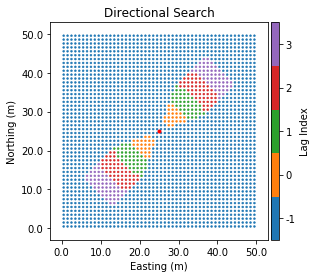

In [54]:
expvario = rmsp.ExpVarioSearch(45.0, 0.0, [5.0, 10.0, 15.0, 20],
                               [2.5, 2.5, 2.5, 2.5], azmtol=25.0,
                               incltol=90.0, azmband=5)
xyz = rmsp.ccg.GSGridDef(dict(nx=50, xcmin=0.5, xsize=1.0,
                              ny=50, ycmin=0.5, ysize=1.0,
                              nz=1, zcmin=0.0, zsize=0.5)).xyzcoords()
df = rmsp.PointData(dict(zip(['x', 'y', 'z'], xyz)), x='x', y='y', z='z')
flagdf = expvario.flagpoints(df, (25.0, 25.0, 0.0))
fig, ax, cax = flagdf.sectionplot('Lag Index', s=3.5,
                                  title='Directional Search')
ax.plot([25.0], [25.0], 'r.')

In [55]:
expvario = rmsp.ExpVarioSearch(0.0, 0.0, [5.0, 10.0, 15.0],
                               [2.5, 2.5, 2.5], azmtol=90.0,
                               incltol=90.0)
xyz = rmsp.ccg.GSGridDef(dict(nx=50, xcmin=0.5, xsize=1.0,
                              ny=50, ycmin=0.5, ysize=1.0,
                              nz=50, zcmin=0.5, zsize=1.0)).xyzcoords()
df = rmsp.PointData(dict(zip(['x', 'y', 'z'], xyz)), x='x', y='y', z='z')
flagdf = expvario.flagpoints(df, (25.0, 25.0, 25.0))
flagdf.head()

,x,y,z,Lag Index
0,0.5,0.5,0.5,-1
1,1.5,0.5,0.5,-1
2,2.5,0.5,0.5,-1
3,3.5,0.5,0.5,-1
4,4.5,0.5,0.5,-1


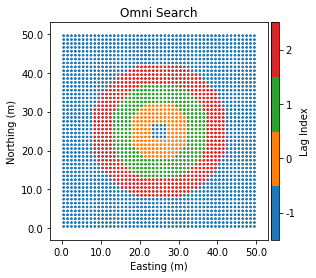

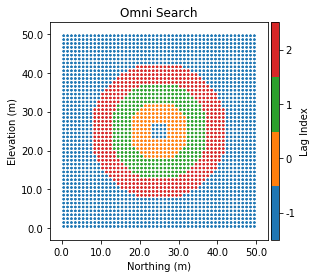

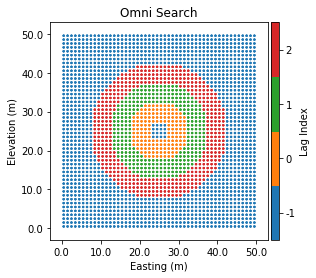

In [57]:
for orient in ["xy", "yz", "xz"]:
    flagdf.sectionplot(
        "Lag Index",
        orient=orient,
        s=3.5,
        title="Omni Search",
        coordinate=(25.0, 25.0, 25.0),
        tolerances=1,
    )

---
# <span style='color:#1B127A;'>Estimate OK</span>

## <span style='color:#5177F9;'> Base Case</span>

In [65]:
varstr = """1    0.0                         -nst, nugget effect
            2    10  0.0   0.0   0.0        -it,cc,ang1,ang2,ang3
            10.0  10.0  10.0            -a_hmax, a_hmin, a_vert"""
variomodel = rmsp.VarioModel(vario_str=varstr)
variomodel.to_table()

,Nugget,Structure 1
Contribution,0.000,10.000
Model Shape,,exponential
Angle 1,,0.0
Angle 2,,0.0
Angle 3,,0.0
Range 1,,10.0
Range 2,,10.0
Range 3,,10.0


In [66]:
ok_est = rmsp.KrigeEstimator(
    ktype="ok",
    search=rmsp.Search(ranges=[100] * 3, min_comps=1, max_comps=20),
    vario=variomodel,
)

In [67]:
ok_est.estimate(
    location, data, "V", output=["estimate", "estimate_var"], accumulate_weights=True
)

,DHID,X,Y,Z,estimate,estimate_var
0,0,65.0,137.0,0.0,592.728943,8.956053


,DHID,X,Y,Z,V,ok_weight
0,1,61.0,139.0,0.0,477,0.172937
1,2,63.0,140.0,0.0,696,0.317794
2,3,64.0,129.0,0.0,227,0.128734
3,4,68.0,128.0,0.0,646,0.086397
4,5,71.0,140.0,0.0,606,0.151128
5,6,73.0,141.0,0.0,791,0.057235
6,7,75.0,128.0,0.0,783,0.085776


,DHID,X,Y,Z,V,ok_weight
0,1,61.0,139.0,0.0,477,0.172937
1,2,63.0,140.0,0.0,696,0.317794
2,3,64.0,129.0,0.0,227,0.128734
3,4,68.0,128.0,0.0,646,0.086397
4,5,71.0,140.0,0.0,606,0.151128
5,6,73.0,141.0,0.0,791,0.057235
6,7,75.0,128.0,0.0,783,0.085776


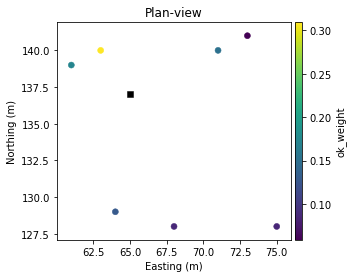

In [69]:
weights = data.copy()
weights['ok_weight'] = ok_est.get_cumulative_weights()
display(weights)
fg,ax,cax = weights.sectionplot(var='ok_weight')
location.sectionplot_draw(ax, 'k', marker='s')

## <span style='color:#5177F9;'> Scaling variogram </span>

Note that this is the scaling of the variogram and not the continuity ranges.

$\gamma_2 = 2\times \gamma_1$

Therefore, its effect is just focused on increasing the variance of the stationary random function.

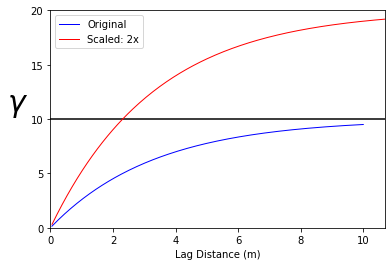

In [28]:
varstr_scaled = """1    0.0                         -nst, nugget effect
            2    20  0.0   0.0   0.0        -it,cc,ang1,ang2,ang3
            10.0  10.0  10.0            -a_hmax, a_hmin, a_vert"""
variomodel_scaled = rmsp.VarioModel(vario_str=varstr_scaled)
fig,ax = variomodel.plot(c='b', label='Original', ylim=[0,20], sill=None)
variomodel_scaled.plot_draw(ax, c='r', label='Scaled: 2x')
ax.legend()

Rescaling the variogram values has not affected the ordinary kriging weights or the ordinary kriging estimate; however, it has affected the ordinary kriging variance. These effects will be observed with any rescaling; while the estimate itself is unchanged, the estimation variance increases by the same factor that was used to scale the variogram

In [35]:
ok_est_scale = rmsp.KrigeEstimator(
    ktype="ok",
    search=rmsp.Search(ranges=[100] * 3, min_comps=1, max_comps=20),
    vario=variomodel_scaled,
)
ok_est_scale.estimate(location, data, 'V',output=['estimate', 'estimate_var'], accumulate_weights=True)

,DHID,X,Y,Z,estimate,estimate_var
0,0,65.0,137.0,0.0,592.728943,17.912106


,DHID,X,Y,Z,V,ok_weight
0,1,61.0,139.0,0.0,477,0.172937
1,2,63.0,140.0,0.0,696,0.317794
2,3,64.0,129.0,0.0,227,0.128734
3,4,68.0,128.0,0.0,646,0.086397
4,5,71.0,140.0,0.0,606,0.151128
5,6,73.0,141.0,0.0,791,0.057235
6,7,75.0,128.0,0.0,783,0.085776


(<matplotlib.collections.PathCollection at 0x256e0fabb08>, None, None)

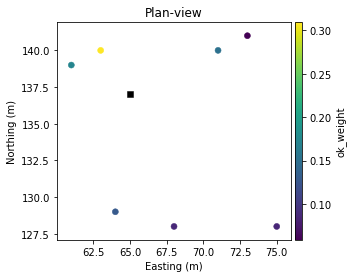

In [71]:
weights_scaled = data.copy()
weights_scaled["ok_weight"] = ok_est_scale.get_cumulative_weights()
display(weights_scaled)
fig, ax, cax = weights_scaled.sectionplot(var="ok_weight")
location.sectionplot_draw(ax, "k", marker="s")

## <span style='color:#5177F9;'> Variogram shape </span>

,Nugget,Structure 1
Contribution,0.000,10.000
Model Shape,,gaussian
Angle 1,,0.0
Angle 2,,0.0
Angle 3,,0.0
Range 1,,10.0
Range 2,,10.0
Range 3,,10.0


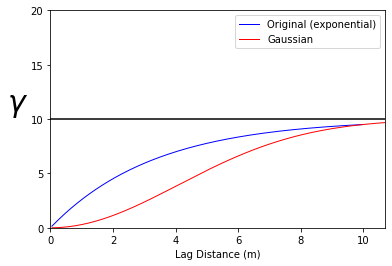

In [73]:
varstr = """1    0.0                         -nst, nugget effect
            3    10  0.0   0.0   0.0        -it,cc,ang1,ang2,ang3
            10.0  10.0  10.0            -a_hmax, a_hmin, a_vert"""
variomodel_gauss = rmsp.VarioModel(vario_str=varstr)

fig,ax = variomodel.plot(c='b', label='Original (exponential)', ylim=[0,20], sill=None)
variomodel_gauss.plot_draw(ax, c='r', label='Gaussian')
ax.legend()

variomodel_gauss.to_table()

In [74]:
ok_est_gauss = rmsp.KrigeEstimator(
    ktype="ok",
    search=rmsp.Search(ranges=[100] * 3, min_comps=1, max_comps=20),
    vario=variomodel_gauss,
)
ok_est_gauss.estimate(location, data, 'V',output=['estimate', 'estimate_var'], accumulate_weights=True)

,DHID,X,Y,Z,estimate,estimate_var
0,0,65.0,137.0,0.0,559.370023,4.780597


With the Gaussian model that is more continuous at short scales/distances, more weight is given to the three values that surround the point being estimated. The appearance of negative weights is a a result of an effect referred to as the <span style="color:red">screen effect</span>. A particular sample is said to be screened if another sample falls between it and the point being estimated. As a result the point being screened gets a very small or negative weight.

The degree to which screened samples lose their influence depends on the pattern of spatial continuity. Note that even with variogram models that are linear rather than parabolic near the origin (Gaussian), it is possible to produce negative weights for samples that are strongly screened by others.

**OK VS IDW/Triangulation**

None of the other estimation procedures can produce negative weights. The advantage of a procedure that can assign weights smaller than 0 or greater than 1 (but still respect the constraint that the sum of the weights is 1) is that it can yield estimates larger than the largest sample value or smaller than the smallest sample value. It is unlikely that the sample data set includes the most extreme values and it is reasonable to imagine that the true values we are trying to estimate may be beyond the extremes of the available sample values


The disadvantage of negative weights is that they also create the possibility of negative estimates if a particularly high sample value is associated with a negative weight (being screened). In most earth science applications, the variable being estimated is necessarily positive. Ore grades and tonnages, porosities, permeabilities, pollutant concentrations, densities, depths to geologic horizons, and thicknesses of strata are common examples of variables that one may be interested in estimating and that are never negative. For such variables, if ordinary kriging produces estimates that are negative, one is perfectly justified in setting such estimates to O.

,DHID,X,Y,Z,V,ok_weight
0,1,61.0,139.0,0.0,477,-0.021514
1,2,63.0,140.0,0.0,696,0.676044
2,3,64.0,129.0,0.0,227,0.165898
3,4,68.0,128.0,0.0,646,-0.012793
4,5,71.0,140.0,0.0,606,0.444086
5,6,73.0,141.0,0.0,791,-0.288446
6,7,75.0,128.0,0.0,783,0.036725


(<matplotlib.collections.PathCollection at 0x256da824488>, None, None)

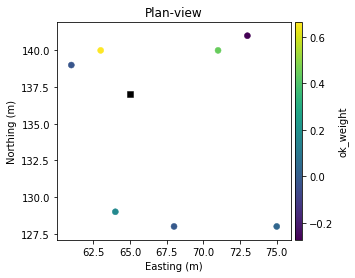

In [76]:
weights_gauss = data.copy()
weights_gauss["ok_weight"] = ok_est_gauss.get_cumulative_weights()
display(weights_gauss)
fig, ax, cax = weights_gauss.sectionplot(var="ok_weight")
location.sectionplot_draw(ax, "k", marker="s")
location

## <span style='color:#5177F9;'> Nugget </span>